# Large Dataset Training

In [1]:
import os
import json
from stelaro.data import synthetic

DATA_DIRECTORY = "../data/"
SUMMARY_DIRECTORY = DATA_DIRECTORY + "ncbi_genome_summaries/"
NCBI_TAXONOMY_DIRECTORY = DATA_DIRECTORY + "ncbi_taxonomy/"
DATASET_V1_DIRECTORY = DATA_DIRECTORY + "version_1/"
DATASET_V1_COMPRESSED_DIRECTORY = DATASET_V1_DIRECTORY + "compressed/"


def mkdir(path: str) -> None:
    """Create a directory if it does not exist."""
    if not os.path.exists(path):
        os.makedirs(path)


mkdir(DATA_DIRECTORY)
mkdir(DATASET_V1_DIRECTORY)
mkdir(DATASET_V1_COMPRESSED_DIRECTORY)

## 1. Compress The Dataset

In [3]:
LENGTH = 1500
with open("../datasets/version_1_splits/map.json", "r") as f:
    index_to_taxonomic_label = json.load(f)

for dataset_name in ("validate", "test", "train"):
    with open(f"../datasets/version_1_splits/{dataset_name}.json", "r") as f:
        dataset = json.load(f)
    index_to_n_passes = {}
    directory = DATASET_V1_COMPRESSED_DIRECTORY + dataset_name + "/"
    mkdir(directory)
    synthetic.compress_dataset(
        dataset,
        index_to_taxonomic_label,
        "../data/version_1/genomes/",
        LENGTH,
        directory
    )

100%|██████████| 27/27 [41:05<00:00, 91.32s/it] 


## 2. Sample Data

In [2]:
f = synthetic.get_n_reads_in_compressed_dataset(
    DATASET_V1_COMPRESSED_DIRECTORY + "test/",
)
print(f)
n = sum(f)
ids = synthetic.get_random_identifiers(n)

[ 12643  22777  34943  31102  60816   4144  64119  86229   5006  25801
   5386   8599  29738  22694  37733  15253  58687 118124  85929 137871
  79875 149174  21096  75607  16687   1920    346]


In [3]:
from numpy import bincount
x, y = synthetic.sample_compressed_dataset(
    DATASET_V1_COMPRESSED_DIRECTORY + "test/",
    200_000,
    1500,
    ids,
    400000
)
print(bincount(y))
print(sum(bincount(y)))

[ 2091  3754  5830  5052 10021   647 10467 14440   800  4357   888  1434
  4802  3723  6316  2519  9638 19468 14160 22791 13193 24595  3484 12415
  2733   330    52]
200000


In [ ]:
import numpy as np
from random import shuffle


def get_floored_random_identifiers(directory: str, floor: int, n: int) -> dict:
    """Same as `get_random_identifiers`, but generates identifiers that
    include all elements of a class if its count is low.
    """
    assert floor > 1, "Invalid floor."
    # Determine the number of samples for each class.
    total_reads = synthetic.get_n_reads_in_compressed_dataset(directory)
    counts_to_fetch = {}
    for i, n_reads in enumerate(total_reads):
        if n_reads < floor:
            counts_to_fetch[i] = int(n_reads)
        else:
            counts_to_fetch[i] = 0
    n_remaining = n - sum(counts_to_fetch.values())
    n_remaining_classes = len([0 for _, v in counts_to_fetch.items() if v == 0])
    average = n_remaining / n_remaining_classes
    for i, n_reads in enumerate(total_reads):
        if counts_to_fetch[i] == 0:
            counts_to_fetch[i] = int(average)
            if average > n_reads:
                raise RuntimeError(f"Insufficient number of reads. Required: {average}. Available: {n_reads}.")
    # Obtain sample indices.
    assert directory.endswith("/")
    with open(directory + "counts.json", "r") as file:
        counts = json.load(file)
    identifiers = {k: [] for k in counts_to_fetch}
    global_index = 0
    for identifier, count in counts.items():
        partial_y = np.load(directory + str(identifier) + "_y.npy")
        partial_y = partial_y[:count]
        for i in range(len(partial_y)):
            identifiers[partial_y[i]].append(global_index)
            global_index += 1
    # Reduce the number of samples.
    indices = []
    for i in range(len(identifiers)):
        shuffle(identifiers[i])
        indices += identifiers[i][:counts_to_fetch[i]]
    shuffle(indices)
    identifiers = {}
    for i, v in enumerate(indices):
        identifiers[i] = v
    return identifiers


indices = get_floored_random_identifiers(
    DATASET_V1_COMPRESSED_DIRECTORY + "test/",
    1000,
    50_000
)

{0: 1069153, 1: 342594, 2: 1109940, 3: 1199448, 4: 3540, 5: 1111912, 6: 417384, 7: 690975, 8: 491436, 9: 355662}


In [14]:
with open(f"../datasets/version_1_splits/train.json", "r") as f:
    dataset = json.load(f)


taxon = dataset[-1]
print(taxon[0])
references = []
for element in taxon[1]:
    genus, ref = element
    references += ref
print(synthetic.evaluate_n_nucleotides(references))


['Viruses', 'Monodnaviria']
5158834


In [7]:
import numpy as np
x = np.load(DATASET_V1_COMPRESSED_DIRECTORY + "train/0_x.npy")
print(x.shape)

(1000000, 375)


## 3. Train Neural Networks

In [2]:
from stelaro import models
from torch.utils.data import DataLoader
import json
from torch.optim import Adam
import matplotlib.pyplot as plt
from stelaro.models import feedforward, autoencoder, transformer, hybrid
from time import time

LENGTH = 1500
BATCH_SIZE = 128
N_SAMPLE_BETWEEN_INTERVALS = 50_000

train_data = DataLoader(
    synthetic.CompressedReadDataset(
        "../data/version_1/compressed/train/", N_SAMPLE_BETWEEN_INTERVALS, 10
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)
validate_data = DataLoader(
    synthetic.SyntheticReadDataset(
        "../data/version_1/compressed/validate/", 50_000, LENGTH, 2000
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)
test_data = DataLoader(
    synthetic.SyntheticReadDataset(
        "../data/version_1/compressed/test/", 100_000, LENGTH, 2000
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)

with open("../datasets/version_1_splits/map.json", "r") as f:
    mapping = json.load(f)


def benchmark(classifier: models.BaseClassifier, name: str, n_max_reads, patience=4):
    train_data.dataset.reset()
    parameters = classifier.get_parameters()
    if parameters:
        optimizer = Adam(classifier.get_parameters(), lr=0.001)
        total_params = sum(param.numel() for param in parameters)
        print(f"Number of parameters: {total_params:_}")
    else:
        optimizer = None
    a = time()
    losses, f1 = classifier.train_large_dataset(
        train_data,
        validate_data,
        optimizer,
        evaluation_interval=N_SAMPLE_BETWEEN_INTERVALS,
        n_max_reads=n_max_reads,
        patience=patience,
    )
    b = time()
    print(f"Training took {(b - a):.3f} s.")
    if losses:
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        x = list(range(len(losses)))
        ax[0].plot(x, losses, label="losses")
        ax[0].set(xlabel='Epochs', ylabel='Loss')
        ax[0].set_title("Loss")
        ax[1].set(xlabel='Epochs', ylabel="f1")
        ax[1].set_title("F1 Score")
        r = 0
        for f in f1:
            ax[1].plot(x, f, label=f'Rank {r}')
            r += 1
        ax[1].legend()
        fig.suptitle(f"Classification Training for {name}")
        plt.show()
    result = models.evaluate(classifier, test_data, "cuda", mapping, permute=False)
    rounded_result = [float(f"{r:.5}") for r in result]
    print(f"Test results: {rounded_result}")
    return classifier


from torch import no_grad, float32
import numpy as np


def confusion_matrix(classifier, loader, device, mapping) -> np.ndarray:
    """Returns: A confusion matrix with rows corresponding to true labels."""
    matrix = np.zeros((len(mapping), len(mapping)))
    with no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.type(float32).to(device)
            #x_batch = x_batch.permute(0, 2, 1)  # Swap channels and sequence.
            y_batch = y_batch.to("cpu")
            predictions = classifier.predict(x_batch)
            for y, p in zip(y_batch, predictions):
                matrix[y][p] += 1
    return matrix

### 3.1. Baseline

In [ ]:
model = benchmark(
    models.RandomClassifier(),
    "Random Classifier",
    n_max_reads=30_000
)
model.n_classes = len(mapping)

  0%|          | 234/68609 [00:00<03:01, 377.43it/s]


Training took 0.622 s.
Test results: [0.32995, 0.032383]


{'0': ['Archaea', 'Thermoproteota'], '1': ['Archaea', 'Halobacteriota'], '2': ['Archaea', 'Methanobacteriota'], '3': ['Bacteria', 'Acidobacteriota'], '4': ['Bacteria', 'Desulfobacterota'], '5': ['Bacteria', 'Aquificota'], '6': ['Bacteria', 'Planctomycetota'], '7': ['Bacteria', 'Myxococcota'], '8': ['Bacteria', 'Synergistota'], '9': ['Bacteria', 'Chloroflexota'], '10': ['Bacteria', 'Thermotogota'], '11': ['Bacteria', 'Deinococcota'], '12': ['Bacteria', 'Cyanobacteriota'], '13': ['Bacteria', 'Bacteroidota_A'], '14': ['Bacteria', 'Fusobacteriota'], '15': ['Bacteria', 'Chlamydiota'], '16': ['Bacteria', 'Spirochaetota'], '17': ['Bacteria', 'Desulfobacterota_I'], '18': ['Bacteria', 'Verrucomicrobiota'], '19': ['Bacteria', 'Bacteroidota'], '20': ['Bacteria', 'Campylobacterota'], '21': ['Bacteria', 'Actinomycetota'], '22': ['Bacteria', 'Bacillota'], '23': ['Bacteria', 'Pseudomonadota'], '24': ['Viruses', 'Duplodnaviria'], '25': ['Viruses', 'Riboviria'], '26': ['Viruses', 'Monodnaviria']}


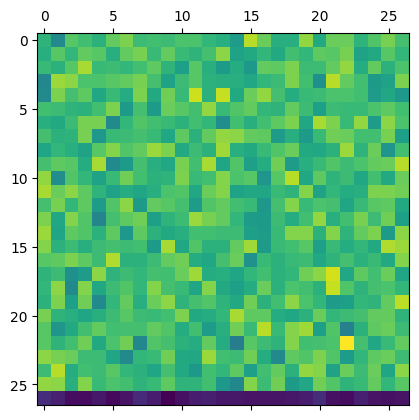

In [ ]:
matrix = confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()

In [7]:
np.set_printoptions(precision=3, suppress=True, linewidth=250)
print(matrix)
print(np.sum(matrix))
print(np.sum(matrix, axis=0))
print(np.sum(matrix, axis=1))

[[67. 51. 75. 71. 66. 77. 81. 70. 71. 70. 73. 73. 68. 65. 58. 89. 78. 65. 65. 84. 63. 78. 78. 67. 74. 80. 72.]
 [65. 75. 68. 77. 75. 65. 77. 80. 69. 77. 69. 67. 72. 83. 60. 63. 68. 63. 71. 68. 76. 75. 80. 60. 63. 75. 68.]
 [69. 66. 75. 87. 69. 70. 68. 71. 76. 67. 59. 75. 65. 57. 64. 56. 77. 76. 81. 70. 70. 77. 84. 64. 77. 66. 73.]
 [50. 85. 83. 73. 73. 75. 77. 80. 72. 60. 70. 75. 66. 65. 65. 62. 68. 70. 81. 71. 53. 89. 77. 71. 57. 60. 81.]
 [51. 81. 72. 76. 62. 69. 64. 81. 63. 79. 69. 92. 66. 91. 63. 78. 84. 72. 64. 69. 70. 73. 73. 71. 58. 62. 56.]
 [71. 70. 67. 66. 71. 81. 57. 72. 57. 78. 75. 71. 84. 69. 74. 77. 68. 67. 77. 70. 59. 70. 69. 69. 73. 76. 71.]
 [65. 63. 70. 80. 80. 51. 68. 74. 71. 69. 66. 71. 68. 52. 71. 65. 71. 76. 81. 62. 87. 81. 69. 84. 58. 83. 73.]
 [72. 66. 67. 80. 56. 69. 70. 72. 69. 62. 76. 66. 77. 84. 83. 77. 76. 58. 65. 57. 69. 79. 78. 71. 71. 80. 59.]
 [61. 68. 65. 60. 75. 82. 74. 77. 85. 81. 63. 70. 66. 86. 65. 63. 69. 74. 78. 63. 62. 66. 85. 67. 78. 55. 71.]
 

### 3.2. CNN

Number of parameters: 35_967_670


  1%|          | 396/68609 [00:19<5:50:06,  3.25it/s]

N Reads: 50048 Loss: 1010.50. F1: [0.30475, 0.053738]. Patience: 4


  1%|          | 784/68609 [00:40<9:59:53,  1.88it/s]

N Reads: 100096 Loss: 879.38. F1: [0.38529, 0.093334]. Patience: 4


  2%|▏         | 1177/68609 [01:02<6:47:38,  2.76it/s]

N Reads: 150144 Loss: 803.85. F1: [0.40049, 0.14599]. Patience: 4


  2%|▏         | 1567/68609 [01:26<8:25:37,  2.21it/s] 

N Reads: 200192 Loss: 761.68. F1: [0.36856, 0.1783]. Patience: 4


  3%|▎         | 1957/68609 [01:47<8:56:13,  2.07it/s]

N Reads: 250240 Loss: 714.40. F1: [0.40692, 0.17854]. Patience: 4


  3%|▎         | 2351/68609 [02:12<8:02:39,  2.29it/s] 

N Reads: 300288 Loss: 685.20. F1: [0.41042, 0.19531]. Patience: 4


  4%|▍         | 2742/68609 [02:34<6:34:21,  2.78it/s]

N Reads: 350336 Loss: 663.34. F1: [0.41068, 0.19997]. Patience: 4


  5%|▍         | 3133/68609 [02:58<8:01:38,  2.27it/s] 

N Reads: 400384 Loss: 643.00. F1: [0.39821, 0.21228]. Patience: 4


  5%|▌         | 3524/68609 [03:21<6:13:26,  2.90it/s]

N Reads: 450432 Loss: 628.73. F1: [0.4019, 0.22195]. Patience: 4


  6%|▌         | 3914/68609 [03:45<7:58:11,  2.25it/s] 

N Reads: 500480 Loss: 615.22. F1: [0.42855, 0.24757]. Patience: 4


  6%|▋         | 4303/68609 [04:07<8:11:16,  2.18it/s]

N Reads: 550528 Loss: 601.61. F1: [0.42689, 0.25745]. Patience: 4


  7%|▋         | 4694/68609 [04:32<10:59:32,  1.62it/s]

N Reads: 600576 Loss: 593.42. F1: [0.44568, 0.26412]. Patience: 4


  7%|▋         | 5085/68609 [04:55<8:28:37,  2.08it/s] 

N Reads: 650624 Loss: 583.25. F1: [0.43684, 0.28328]. Patience: 4


  8%|▊         | 5478/68609 [05:21<7:57:48,  2.20it/s] 

N Reads: 700672 Loss: 579.03. F1: [0.46303, 0.24641]. Patience: 3


  9%|▊         | 5867/68609 [05:45<8:35:37,  2.03it/s]

N Reads: 750720 Loss: 566.52. F1: [0.4374, 0.29428]. Patience: 3


  9%|▉         | 6261/68609 [06:11<8:10:37,  2.12it/s] 

N Reads: 800768 Loss: 562.48. F1: [0.47543, 0.29603]. Patience: 3


 10%|▉         | 6651/68609 [06:35<6:13:21,  2.77it/s]

N Reads: 850816 Loss: 555.06. F1: [0.46326, 0.26431]. Patience: 2


 10%|█         | 7042/68609 [07:02<8:08:56,  2.10it/s] 

N Reads: 900864 Loss: 558.89. F1: [0.51249, 0.28875]. Patience: 1


 11%|█         | 7432/68609 [07:26<8:21:03,  2.03it/s]

N Reads: 950912 Loss: 546.36. F1: [0.4639, 0.29811]. Patience: 1


 11%|█▏        | 7824/68609 [07:53<8:25:21,  2.00it/s] 

N Reads: 1000960 Loss: 542.37. F1: [0.49557, 0.31291]. Patience: 1


 12%|█▏        | 8210/68609 [08:18<1:01:06, 16.47it/s]

N Reads: 1051008 Loss: 535.93. F1: [0.48375, 0.31049]. Patience: 0
The model is overfitting; stopping early.
Processed 1_051_008 reads.
Training took 498.417 s.


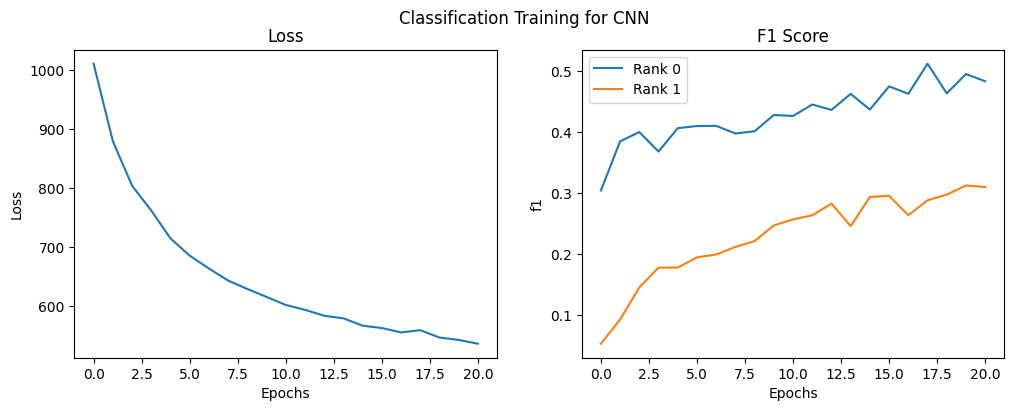

Test results: [0.5222, 0.32266]


In [11]:
from torch.nn import (Module, Conv1d, ReLU, Sequential, Flatten, Linear,
                      CrossEntropyLoss, Dropout, MaxPool1d)
from torch import stack, tensor, float32
from torch.func import vmap
import torch.nn.functional as F


class CNN_2_dropout_token(Module):
    def __init__(self, N, M):
        super(CNN_2_dropout_token, self).__init__()
        self.conv = Sequential(
            Conv1d(4, 32, kernel_size=7, padding=3),
            ReLU(),
            Conv1d(32, 64, kernel_size=5, padding=2),
            ReLU(),
            Conv1d(64, 128, kernel_size=3, padding=1),
            ReLU(),
        )
        n = N * 4
        self.fc = Sequential(
            Flatten(),
            Dropout(0.2),
            Linear(n * 128, int(n / 8)),
            ReLU(),
            Dropout(0.2),
            Linear(int(n / 8), 128),
            ReLU(),
            Dropout(0.2),
            Linear(128, M)
        )

    def forward(self, x):
        B, N = x.shape
        shifts = tensor([6, 4, 2, 0], device=x.device).view(1, 1, 4)
        x_expanded = x.unsqueeze(-1).to(int)
        tokens = (x_expanded >> shifts) & 0b11
        tokens = tokens.view(B, N * 4)
        one_hot = F.one_hot(tokens, num_classes=4).float()
        x = one_hot.permute(0, 2, 1)
        x = self.conv(x)
        x = self.fc(x)
        return x.to(float)


model = benchmark(
    feedforward.Classifier(LENGTH // 4, mapping, "cuda", CNN_2_dropout_token),
    "CNN",
    n_max_reads=1_200_000
)

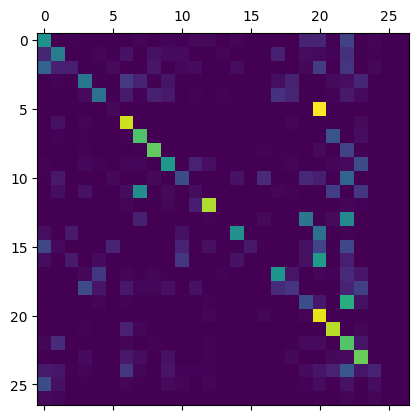

[[1909.    8.   35.    2.    0.    0.    0.   46.    9.   56.   40.   94.   82.    0.   67.    3.    4.    0.    0.  353.  388.   21.  730.    1.   70.    0.    0.]
 [ 391. 1593.   10.    6.   63.   21.  183.    3.  172.  108.  113.   13.    2.   58.    3.    2.   22.  325.    9.  124.   81.   35.  518.   24.   30.    0.    0.]
 [1188.  325.  319.    0.   15.   93.    0.    0.  230.    0.   76.  112.    2.    0.  121.    0.   11.    0.    0.   87.  673.    0.  582.    0.   75.    0.    0.]
 [   1.   35.    0. 1467.   24.    0.  618.  366.   24.  219.    5.   19.    5.   11.    0.    0.    0.  140.  349.    2.    1.   88.  142.  391.    2.    0.    0.]
 [   2.   27.    0.  100. 1417.    0.  276.   33.  334.  258.    3.   35.    8.   43.    0.    0.   25.  536.  392.   16.    3.   38.  257.  104.    2.    0.    0.]
 [  20.    3.    1.    0.    0.   81.    0.    0.    0.    4.    6.    8.    8.    0.    9.    0.    2.    0.    1.    8. 3753.    0.    5.    0.    0.    0.    0.]
 [   0.  1

In [13]:
matrix = confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=250)
print(matrix)

### 3.3. Transformer

Number of parameters: 679_067


  1%|          | 391/68609 [01:45<133:31:49,  7.05s/it]

N Reads: 50048 Loss: 911.77. F1: [0.4971, 0.17448]. Patience: 20


  1%|          | 782/68609 [03:42<187:16:23,  9.94s/it]

N Reads: 100096 Loss: 713.89. F1: [0.55589, 0.26355]. Patience: 20


  2%|▏         | 1173/68609 [05:35<148:52:10,  7.95s/it]

N Reads: 150144 Loss: 646.07. F1: [0.58945, 0.28393]. Patience: 20


  2%|▏         | 1564/68609 [07:31<147:50:52,  7.94s/it]

N Reads: 200192 Loss: 609.63. F1: [0.59354, 0.31574]. Patience: 20


  3%|▎         | 1955/68609 [09:28<150:28:02,  8.13s/it]

N Reads: 250240 Loss: 583.18. F1: [0.59814, 0.33352]. Patience: 20


  3%|▎         | 2346/68609 [11:26<146:50:00,  7.98s/it]

N Reads: 300288 Loss: 558.93. F1: [0.60293, 0.332]. Patience: 19


  4%|▍         | 2737/68609 [13:27<154:43:31,  8.46s/it]

N Reads: 350336 Loss: 538.76. F1: [0.61918, 0.35396]. Patience: 19


  5%|▍         | 3128/68609 [15:26<148:29:09,  8.16s/it]

N Reads: 400384 Loss: 524.40. F1: [0.62173, 0.37399]. Patience: 19


  5%|▌         | 3519/68609 [17:25<142:23:27,  7.88s/it]

N Reads: 450432 Loss: 508.73. F1: [0.62608, 0.36779]. Patience: 18


  6%|▌         | 3910/68609 [19:25<145:07:12,  8.07s/it]

N Reads: 500480 Loss: 497.27. F1: [0.62774, 0.3496]. Patience: 17


  6%|▋         | 4301/68609 [21:25<145:01:48,  8.12s/it]

N Reads: 550528 Loss: 486.27. F1: [0.5917, 0.37578]. Patience: 17


  7%|▋         | 4692/68609 [23:25<144:06:42,  8.12s/it]

N Reads: 600576 Loss: 477.84. F1: [0.64792, 0.39183]. Patience: 17


  7%|▋         | 5083/68609 [25:28<147:15:04,  8.34s/it]

N Reads: 650624 Loss: 471.44. F1: [0.67596, 0.41339]. Patience: 17


  8%|▊         | 5474/68609 [27:29<139:55:18,  7.98s/it]

N Reads: 700672 Loss: 462.65. F1: [0.65489, 0.40595]. Patience: 16


  9%|▊         | 5865/68609 [29:32<143:19:04,  8.22s/it]

N Reads: 750720 Loss: 453.41. F1: [0.67, 0.40212]. Patience: 15


  9%|▉         | 6256/68609 [31:33<137:14:57,  7.92s/it]

N Reads: 800768 Loss: 451.60. F1: [0.6648, 0.41126]. Patience: 14


 10%|▉         | 6647/68609 [33:33<136:55:44,  7.96s/it]

N Reads: 850816 Loss: 440.37. F1: [0.67993, 0.42699]. Patience: 14


 10%|█         | 7038/68609 [35:33<133:38:12,  7.81s/it]

N Reads: 900864 Loss: 435.16. F1: [0.66747, 0.42261]. Patience: 13


 11%|█         | 7429/68609 [37:34<134:38:18,  7.92s/it]

N Reads: 950912 Loss: 429.51. F1: [0.66735, 0.41671]. Patience: 12


 11%|█▏        | 7820/68609 [39:36<135:30:43,  8.03s/it]

N Reads: 1000960 Loss: 422.49. F1: [0.66844, 0.42615]. Patience: 11


 12%|█▏        | 8211/68609 [41:37<134:24:39,  8.01s/it]

N Reads: 1051008 Loss: 421.97. F1: [0.65132, 0.42881]. Patience: 11


 13%|█▎        | 8602/68609 [44:06<127:34:18,  7.65s/it]

N Reads: 1101056 Loss: 414.97. F1: [0.6672, 0.43109]. Patience: 11


 13%|█▎        | 8993/68609 [46:07<132:59:39,  8.03s/it]

N Reads: 1151104 Loss: 412.76. F1: [0.67095, 0.42272]. Patience: 10


 14%|█▎        | 9384/68609 [48:10<132:20:37,  8.04s/it]

N Reads: 1201152 Loss: 407.97. F1: [0.68575, 0.44674]. Patience: 10


 14%|█▍        | 9775/68609 [50:13<131:06:48,  8.02s/it]

N Reads: 1251200 Loss: 402.85. F1: [0.67516, 0.43399]. Patience: 9


 15%|█▍        | 10166/68609 [52:18<132:48:25,  8.18s/it]

N Reads: 1301248 Loss: 400.00. F1: [0.65776, 0.43275]. Patience: 8


 15%|█▌        | 10557/68609 [54:22<131:15:02,  8.14s/it]

N Reads: 1351296 Loss: 395.11. F1: [0.68288, 0.44628]. Patience: 7


 16%|█▌        | 10948/68609 [56:27<128:06:49,  8.00s/it]

N Reads: 1401344 Loss: 391.79. F1: [0.68724, 0.44161]. Patience: 6


 17%|█▋        | 11339/68609 [58:28<123:29:23,  7.76s/it]

N Reads: 1451392 Loss: 388.66. F1: [0.68047, 0.44923]. Patience: 6


 17%|█▋        | 11730/68609 [1:00:28<121:23:26,  7.68s/it]

N Reads: 1501440 Loss: 385.04. F1: [0.68823, 0.45717]. Patience: 6


 18%|█▊        | 12121/68609 [1:02:28<121:56:56,  7.77s/it]

N Reads: 1551488 Loss: 379.60. F1: [0.68229, 0.44999]. Patience: 5


 18%|█▊        | 12512/68609 [1:04:30<123:52:47,  7.95s/it]

N Reads: 1601536 Loss: 379.15. F1: [0.68056, 0.45731]. Patience: 5


 19%|█▉        | 12903/68609 [1:06:31<121:02:47,  7.82s/it]

N Reads: 1651584 Loss: 375.35. F1: [0.67188, 0.43718]. Patience: 4


 19%|█▉        | 13294/68609 [1:08:31<118:08:41,  7.69s/it]

N Reads: 1701632 Loss: 378.56. F1: [0.67975, 0.45168]. Patience: 3


 20%|█▉        | 13685/68609 [1:10:32<118:31:09,  7.77s/it]

N Reads: 1751680 Loss: 377.47. F1: [0.70451, 0.4554]. Patience: 2


 21%|██        | 14076/68609 [1:12:33<115:36:26,  7.63s/it]

N Reads: 1801728 Loss: 368.50. F1: [0.68398, 0.43696]. Patience: 1


 21%|██        | 14466/68609 [1:14:35<4:39:09,  3.23it/s]  

N Reads: 1851776 Loss: 368.06. F1: [0.69193, 0.44601]. Patience: 0
The model is overfitting; stopping early.
Processed 1_851_776 reads.
Training took 4475.196 s.


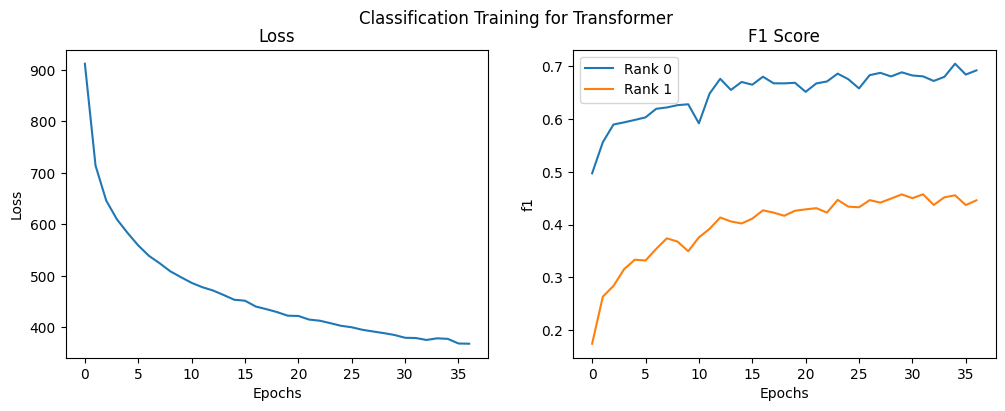

Test results: [0.69433, 0.43965]


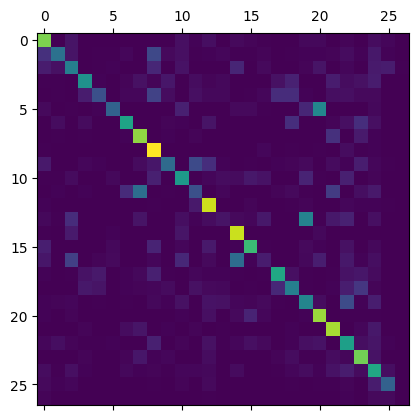

[[2859.    1.  182.    0.    0.    2.    0.    1.    0.    0.  147.   36.  135.    1.   86.   45.   14.    0.    0.   81.   81.    8.   50.    6.  123.   60.    0.]
 [ 496. 1331.  184.    4.   26.   19.   66.    9.  776.   84.  144.   15.   37.   68.   19.   20.   45.   11.   22.   41.   32.   47.  117.   31.  235.   29.    1.]
 [ 268.  163. 1535.    0.   18.   33.    3.    0.  384.    0.  167.    9.   11.    1.  365.    1.   92.   11.    0.   54.  190.    0.   58.    4.  259.  269.   14.]
 [  15.   16.    1. 1798.   29.    0.   52.  161.   47.  212.    2.  114.   49.   73.    0.    1.   13.  157.  322.   11.    5.  277.  118.  161.  269.    5.    1.]
 [   9.   27.   12.  273.  861.    0.   57.   57.  703.  114.   10.  148.   79.   80.    0.   17.   56.  449.  456.   34.    8.  130.  143.   96.   86.    4.    0.]
 [  93.    0.   19.    0.   32. 1122.    8.    0.    5.    0.  317.    0.    3.    0.   84.   86.   17.    0.    0.  386. 1644.    0.   13.    2.   76.    2.    0.]
 [   1.  1

In [11]:
from torch import  arange
from torch.nn import (Module, Linear, Embedding, TransformerEncoderLayer,
                      TransformerEncoder)


class T_1_tokens(Module):
    def __init__(self, N, M):
        super(T_1_tokens, self).__init__()
        embed_dim = 128
        self.token_embedding = Embedding(256, embed_dim)
        self.position_embedding = Embedding(N, embed_dim)
        encoder_layer = TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=8,
            dim_feedforward=embed_dim * 4,
            dropout=0.1,
            activation='relu',
            batch_first=True  # makes input/output shape [B, L, D]
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=3)
        self.classifier = Linear(embed_dim, M)

    def forward(self, x):
        batch_size, seq_len = x.size()
        positions = arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        x = self.token_embedding(x) + self.position_embedding(positions)  # [B, L, D]
        x = self.transformer_encoder(x)  # [B, L, D]
        x = x.mean(dim=1)  # [B, D] - average pooling
        logits = self.classifier(x)  # [B, num_classes]
        return logits


model = benchmark(
    transformer.Classifier(LENGTH // 4, mapping, "cuda", T_1_tokens, use_tokens=True),
    "Transformer",
    n_max_reads=8_000_000,
    patience=20,
)
matrix = confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=250)
print(matrix)

Number of parameters: 480_795


  1%|          | 392/68609 [01:12<65:57:18,  3.48s/it]

N Reads: 50048 Loss: 895.81. F1: [0.46784, 0.1771]. Patience: 20


  1%|          | 783/68609 [02:25<70:57:30,  3.77s/it] 

N Reads: 100096 Loss: 690.63. F1: [0.57019, 0.29199]. Patience: 20


  2%|▏         | 1174/68609 [03:39<70:56:33,  3.79s/it] 

N Reads: 150144 Loss: 629.58. F1: [0.59446, 0.3008]. Patience: 20


  2%|▏         | 1565/68609 [04:53<70:54:31,  3.81s/it] 

N Reads: 200192 Loss: 587.66. F1: [0.60096, 0.32612]. Patience: 20


  3%|▎         | 1956/68609 [06:08<69:32:19,  3.76s/it]

N Reads: 250240 Loss: 561.38. F1: [0.61885, 0.36086]. Patience: 20


  3%|▎         | 2347/68609 [07:24<67:56:42,  3.69s/it]

N Reads: 300288 Loss: 533.71. F1: [0.63972, 0.36957]. Patience: 20


  4%|▍         | 2738/68609 [08:40<67:45:58,  3.70s/it]

N Reads: 350336 Loss: 515.96. F1: [0.62479, 0.38126]. Patience: 20


  5%|▍         | 3129/68609 [09:56<67:36:09,  3.72s/it]

N Reads: 400384 Loss: 499.09. F1: [0.64054, 0.39052]. Patience: 20


  5%|▌         | 3520/68609 [11:12<67:09:27,  3.71s/it]

N Reads: 450432 Loss: 485.84. F1: [0.66148, 0.39634]. Patience: 20


  6%|▌         | 3911/68609 [12:28<66:16:57,  3.69s/it]

N Reads: 500480 Loss: 473.83. F1: [0.66595, 0.39364]. Patience: 19


  6%|▋         | 4302/68609 [13:46<67:10:30,  3.76s/it]

N Reads: 550528 Loss: 463.12. F1: [0.62791, 0.40598]. Patience: 19


  7%|▋         | 4693/68609 [15:03<65:59:30,  3.72s/it]

N Reads: 600576 Loss: 453.21. F1: [0.66566, 0.416]. Patience: 19


  7%|▋         | 5084/68609 [16:20<65:10:18,  3.69s/it]

N Reads: 650624 Loss: 447.43. F1: [0.6564, 0.41712]. Patience: 19


  8%|▊         | 5475/68609 [17:37<65:47:58,  3.75s/it]

N Reads: 700672 Loss: 438.90. F1: [0.67232, 0.40982]. Patience: 18


  9%|▊         | 5866/68609 [18:55<64:11:42,  3.68s/it]

N Reads: 750720 Loss: 429.07. F1: [0.69189, 0.42246]. Patience: 18


  9%|▉         | 6257/68609 [20:12<64:05:49,  3.70s/it]

N Reads: 800768 Loss: 425.75. F1: [0.67859, 0.43344]. Patience: 18


 10%|▉         | 6648/68609 [21:29<62:31:11,  3.63s/it]

N Reads: 850816 Loss: 416.52. F1: [0.67841, 0.44525]. Patience: 18


 10%|█         | 7039/68609 [22:46<62:26:58,  3.65s/it]

N Reads: 900864 Loss: 409.97. F1: [0.69049, 0.44184]. Patience: 17


 11%|█         | 7430/68609 [24:03<61:21:29,  3.61s/it]

N Reads: 950912 Loss: 406.28. F1: [0.66943, 0.42561]. Patience: 16


 11%|█▏        | 7821/68609 [25:20<61:01:36,  3.61s/it]

N Reads: 1000960 Loss: 400.27. F1: [0.68578, 0.44743]. Patience: 16


 12%|█▏        | 8212/68609 [26:36<60:35:41,  3.61s/it]

N Reads: 1051008 Loss: 400.44. F1: [0.66068, 0.43885]. Patience: 15


 13%|█▎        | 8603/68609 [27:54<59:59:50,  3.60s/it]

N Reads: 1101056 Loss: 393.40. F1: [0.67331, 0.44367]. Patience: 14


 13%|█▎        | 8994/68609 [29:11<59:37:33,  3.60s/it]

N Reads: 1151104 Loss: 391.51. F1: [0.6776, 0.44116]. Patience: 13


 14%|█▎        | 9385/68609 [30:28<59:00:19,  3.59s/it]

N Reads: 1201152 Loss: 388.32. F1: [0.70119, 0.46333]. Patience: 13


 14%|█▍        | 9776/68609 [31:46<60:26:36,  3.70s/it]

N Reads: 1251200 Loss: 384.09. F1: [0.66555, 0.4484]. Patience: 12


 15%|█▍        | 10167/68609 [33:04<58:52:54,  3.63s/it]

N Reads: 1301248 Loss: 380.60. F1: [0.66798, 0.45391]. Patience: 11


 15%|█▌        | 10558/68609 [34:22<58:42:37,  3.64s/it]

N Reads: 1351296 Loss: 377.24. F1: [0.6869, 0.45463]. Patience: 10


 16%|█▌        | 10949/68609 [35:40<56:34:51,  3.53s/it]

N Reads: 1401344 Loss: 373.13. F1: [0.68748, 0.4581]. Patience: 9


 17%|█▋        | 11340/68609 [36:59<59:24:45,  3.73s/it]

N Reads: 1451392 Loss: 372.45. F1: [0.6872, 0.45328]. Patience: 8


 17%|█▋        | 11731/68609 [38:20<57:59:41,  3.67s/it]

N Reads: 1501440 Loss: 370.11. F1: [0.68564, 0.46823]. Patience: 8


 18%|█▊        | 12122/68609 [39:39<57:24:59,  3.66s/it]

N Reads: 1551488 Loss: 363.59. F1: [0.68819, 0.4616]. Patience: 7


 18%|█▊        | 12513/68609 [40:57<54:51:14,  3.52s/it]

N Reads: 1601536 Loss: 362.51. F1: [0.69532, 0.46556]. Patience: 6


 19%|█▉        | 12904/68609 [42:15<54:34:56,  3.53s/it]

N Reads: 1651584 Loss: 360.88. F1: [0.67659, 0.44712]. Patience: 5


 19%|█▉        | 13295/68609 [43:33<54:03:21,  3.52s/it]

N Reads: 1701632 Loss: 362.45. F1: [0.69595, 0.45446]. Patience: 4


 20%|█▉        | 13686/68609 [44:52<55:54:39,  3.66s/it]

N Reads: 1751680 Loss: 358.41. F1: [0.69712, 0.47419]. Patience: 4


 21%|██        | 14077/68609 [46:12<54:41:44,  3.61s/it]

N Reads: 1801728 Loss: 353.14. F1: [0.69421, 0.46204]. Patience: 3


 21%|██        | 14468/68609 [47:30<53:21:36,  3.55s/it]

N Reads: 1851776 Loss: 352.85. F1: [0.70327, 0.46728]. Patience: 2


 22%|██▏       | 14859/68609 [48:49<53:38:12,  3.59s/it]

N Reads: 1901824 Loss: 349.68. F1: [0.67306, 0.45246]. Patience: 1


 22%|██▏       | 15248/68609 [50:08<2:55:28,  5.07it/s] 

N Reads: 1951872 Loss: 346.52. F1: [0.68995, 0.46088]. Patience: 0
The model is overfitting; stopping early.
Processed 1_951_872 reads.


Training took 3008.956 s.


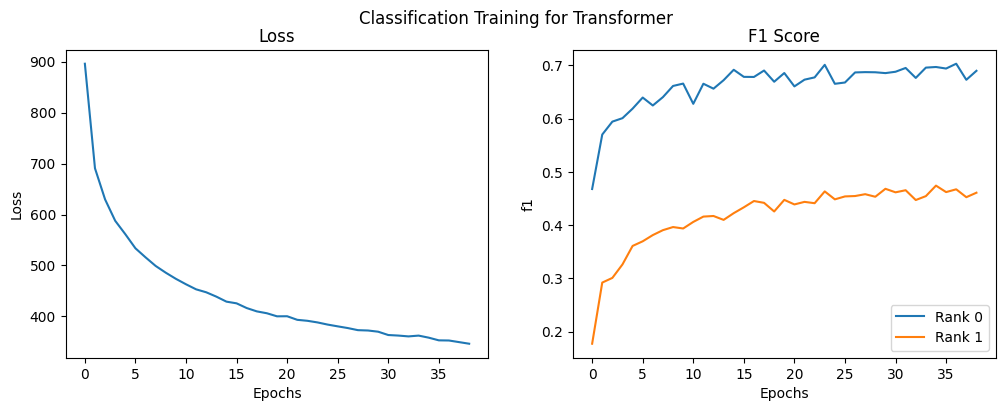

Test results: [0.70656, 0.47211]


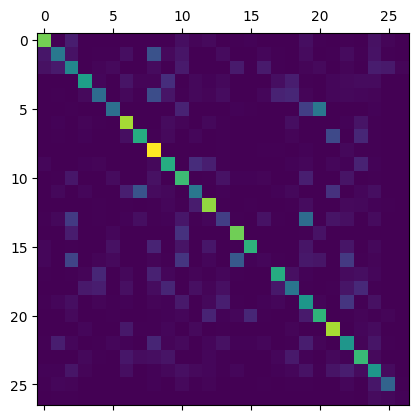

[[2851.   13.  296.    0.    0.    5.    2.    0.    5.    8.  132.   44.   95.    5.   20.   29.   13.    0.    0.  129.   15.    8.   28.    1.  165.   53.    1.]
 [ 215. 1445.  178.    1.   18.   15.  140.    6.  904.   85.  199.   11.   14.  107.    6.    7.   57.   26.   10.   99.   10.   21.  106.   23.  181.   24.    1.]
 [ 157.  256. 1679.    0.   50.   86.    0.    0.  110.    2.  257.    9.    2.    2.  268.    0.  259.   17.    0.   44.   92.    0.   53.    2.  275.  246.   43.]
 [  14.   13.    0. 2044.   64.    0.  184.   43.   48.  466.    9.   77.   33.   78.    0.    1.    5.  132.  288.   25.    6.   70.   90.  112.   99.    8.    0.]
 [   6.   23.    3.   87. 1273.    0.   76.   20.  849.  200.   18.   81.   44.  114.    0.    3.   60.  350.  381.   49.   14.   63.   82.   57.   50.    5.    1.]
 [   8.    0.   21.    0.    6. 1318.    4.    0.    2.    0.  341.    1.    5.    0.   36.   16.    3.    0.    0.  664. 1429.    0.   14.    0.   39.    2.    0.]
 [   0.   

In [8]:
from torch import arange
from torch.nn import (Module, Linear, Embedding, TransformerEncoderLayer,
                      TransformerEncoder)


class T_2_tokens(Module):
    def __init__(self, N, M):
        super(T_2_tokens, self).__init__()
        embed_dim = 128
        self.token_embedding = Embedding(256, embed_dim)
        self.position_embedding = Embedding(N, embed_dim)
        encoder_layer = TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=8,
            dim_feedforward=embed_dim * 4,
            dropout=0.1,
            activation='relu',
            batch_first=True  # makes input/output shape [B, L, D]
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=2)
        self.classifier = Linear(embed_dim, M)

    def forward(self, x):
        batch_size, seq_len = x.size()
        positions = arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        x = self.token_embedding(x) + self.position_embedding(positions)  # [B, L, D]
        x = self.transformer_encoder(x)  # [B, L, D]
        x = x.mean(dim=1)  # [B, D] - average pooling
        logits = self.classifier(x)  # [B, num_classes]
        return logits


model = benchmark(
    transformer.Classifier(LENGTH // 4, mapping, "cuda", T_2_tokens, use_tokens=True),
    "Transformer",
    n_max_reads=8_000_000,
    patience=20,
)
matrix = confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=250)
print(matrix)

### 3.4. Autoencoders

Number of parameters: 73_427_257


  1%|          | 395/68609 [00:27<7:44:38,  2.45it/s] 

N Reads: 50048 Loss: 314.75. F1: [0.35615, 0.070641]. Patience: 30


  1%|          | 787/68609 [00:48<9:50:22,  1.91it/s] 

N Reads: 100096 Loss: 281.67. F1: [0.40199, 0.11616]. Patience: 30


  2%|▏         | 1177/68609 [01:09<10:09:29,  1.84it/s]

N Reads: 150144 Loss: 264.40. F1: [0.47945, 0.14751]. Patience: 30


  2%|▏         | 1566/68609 [01:30<13:12:24,  1.41it/s]

N Reads: 200192 Loss: 245.43. F1: [0.49689, 0.20127]. Patience: 30


  3%|▎         | 1957/68609 [01:51<13:10:09,  1.41it/s]

N Reads: 250240 Loss: 234.45. F1: [0.41366, 0.20009]. Patience: 29


  3%|▎         | 2350/68609 [02:13<9:51:29,  1.87it/s] 

N Reads: 300288 Loss: 226.84. F1: [0.43025, 0.23759]. Patience: 29


  4%|▍         | 2740/68609 [02:34<10:42:38,  1.71it/s]

N Reads: 350336 Loss: 221.63. F1: [0.50459, 0.25269]. Patience: 29


  5%|▍         | 3132/68609 [02:56<10:58:47,  1.66it/s]

N Reads: 400384 Loss: 217.29. F1: [0.44896, 0.26531]. Patience: 29


  5%|▌         | 3523/68609 [03:18<10:28:57,  1.72it/s]

N Reads: 450432 Loss: 213.08. F1: [0.51503, 0.27383]. Patience: 29


  6%|▌         | 3912/68609 [03:40<13:45:05,  1.31it/s]

N Reads: 500480 Loss: 209.25. F1: [0.52694, 0.27584]. Patience: 29


  6%|▋         | 4304/68609 [04:02<10:13:40,  1.75it/s]

N Reads: 550528 Loss: 206.04. F1: [0.50893, 0.29217]. Patience: 29


  7%|▋         | 4695/68609 [04:24<9:43:11,  1.83it/s] 

N Reads: 600576 Loss: 202.98. F1: [0.54184, 0.3127]. Patience: 29


  7%|▋         | 5087/68609 [04:45<9:16:21,  1.90it/s] 

N Reads: 650624 Loss: 200.85. F1: [0.50163, 0.2967]. Patience: 28


  8%|▊         | 5478/68609 [05:08<9:10:50,  1.91it/s] 

N Reads: 700672 Loss: 198.46. F1: [0.55178, 0.33589]. Patience: 28


  9%|▊         | 5868/68609 [05:30<9:35:44,  1.82it/s] 

N Reads: 750720 Loss: 195.18. F1: [0.55984, 0.31515]. Patience: 27


  9%|▉         | 6259/68609 [05:52<10:40:47,  1.62it/s]

N Reads: 800768 Loss: 195.12. F1: [0.60989, 0.34755]. Patience: 27


 10%|▉         | 6650/68609 [06:15<10:51:55,  1.58it/s]

N Reads: 850816 Loss: 193.25. F1: [0.62941, 0.37061]. Patience: 27


 10%|█         | 7040/68609 [06:38<13:12:20,  1.30it/s]

N Reads: 900864 Loss: 191.06. F1: [0.56294, 0.33412]. Patience: 26


 11%|█         | 7433/68609 [07:01<9:02:38,  1.88it/s] 

N Reads: 950912 Loss: 190.02. F1: [0.61369, 0.353]. Patience: 25


 11%|█▏        | 7823/68609 [07:24<9:12:41,  1.83it/s] 

N Reads: 1000960 Loss: 187.54. F1: [0.57164, 0.33991]. Patience: 24


 12%|█▏        | 8214/68609 [07:49<11:17:23,  1.49it/s]

N Reads: 1051008 Loss: 186.90. F1: [0.55528, 0.36551]. Patience: 23


 13%|█▎        | 8607/68609 [08:11<7:40:23,  2.17it/s] 

N Reads: 1101056 Loss: 186.61. F1: [0.58116, 0.36923]. Patience: 22


 13%|█▎        | 8997/68609 [08:33<7:34:15,  2.19it/s] 

N Reads: 1151104 Loss: 183.47. F1: [0.63061, 0.39051]. Patience: 22


 14%|█▎        | 9387/68609 [08:56<8:51:50,  1.86it/s] 

N Reads: 1201152 Loss: 183.31. F1: [0.62816, 0.38946]. Patience: 21


 14%|█▍        | 9777/68609 [09:19<11:54:38,  1.37it/s]

N Reads: 1251200 Loss: 183.35. F1: [0.64102, 0.39166]. Patience: 21


 15%|█▍        | 10169/68609 [09:42<8:49:44,  1.84it/s] 

N Reads: 1301248 Loss: 182.03. F1: [0.58628, 0.37172]. Patience: 20


 15%|█▌        | 10561/68609 [10:05<7:30:48,  2.15it/s] 

N Reads: 1351296 Loss: 179.56. F1: [0.64871, 0.40405]. Patience: 20


 16%|█▌        | 10951/68609 [10:28<8:23:18,  1.91it/s] 

N Reads: 1401344 Loss: 179.47. F1: [0.64357, 0.39274]. Patience: 19


 17%|█▋        | 11344/68609 [10:51<7:13:28,  2.20it/s] 

N Reads: 1451392 Loss: 180.00. F1: [0.62574, 0.39921]. Patience: 18


 17%|█▋        | 11734/68609 [11:14<7:38:27,  2.07it/s] 

N Reads: 1501440 Loss: 178.37. F1: [0.61565, 0.41102]. Patience: 18


 18%|█▊        | 12124/68609 [11:38<8:28:44,  1.85it/s] 

N Reads: 1551488 Loss: 175.95. F1: [0.6435, 0.41247]. Patience: 18


 18%|█▊        | 12514/68609 [12:02<11:11:13,  1.39it/s]

N Reads: 1601536 Loss: 175.66. F1: [0.62886, 0.397]. Patience: 17


 19%|█▉        | 12907/68609 [12:26<8:00:49,  1.93it/s] 

N Reads: 1651584 Loss: 175.08. F1: [0.65311, 0.4045]. Patience: 16


 19%|█▉        | 13297/68609 [12:53<9:40:48,  1.59it/s] 

N Reads: 1701632 Loss: 177.00. F1: [0.6614, 0.42409]. Patience: 16


 20%|█▉        | 13689/68609 [13:17<6:46:11,  2.25it/s]

N Reads: 1751680 Loss: 175.12. F1: [0.67439, 0.4127]. Patience: 15


 21%|██        | 14079/68609 [13:40<6:45:29,  2.24it/s]

N Reads: 1801728 Loss: 173.24. F1: [0.67286, 0.4047]. Patience: 14


 21%|██        | 14469/68609 [14:03<9:12:37,  1.63it/s]

N Reads: 1851776 Loss: 172.94. F1: [0.65063, 0.39881]. Patience: 13


 22%|██▏       | 14862/68609 [14:26<6:29:30,  2.30it/s]

N Reads: 1901824 Loss: 171.74. F1: [0.66558, 0.40871]. Patience: 12


 22%|██▏       | 15252/68609 [14:49<6:37:13,  2.24it/s]

N Reads: 1951872 Loss: 171.46. F1: [0.65953, 0.39119]. Patience: 11


 23%|██▎       | 15642/68609 [15:12<8:49:53,  1.67it/s]

N Reads: 2001920 Loss: 169.86. F1: [0.65775, 0.42315]. Patience: 10


 23%|██▎       | 16034/68609 [15:35<6:22:04,  2.29it/s]

N Reads: 2051968 Loss: 170.85. F1: [0.66588, 0.41423]. Patience: 9


 24%|██▍       | 16427/68609 [15:58<6:15:49,  2.31it/s]

N Reads: 2102016 Loss: 170.17. F1: [0.66533, 0.40376]. Patience: 8


 25%|██▍       | 16817/68609 [16:21<6:15:18,  2.30it/s]

N Reads: 2152064 Loss: 168.61. F1: [0.64297, 0.39754]. Patience: 7


 25%|██▌       | 17207/68609 [16:45<6:14:15,  2.29it/s]

N Reads: 2202112 Loss: 168.72. F1: [0.66909, 0.42075]. Patience: 6


 26%|██▌       | 17600/68609 [17:08<6:20:53,  2.23it/s]

N Reads: 2252160 Loss: 168.01. F1: [0.66643, 0.40902]. Patience: 5


 26%|██▌       | 17990/68609 [17:32<6:02:08,  2.33it/s]

N Reads: 2302208 Loss: 167.09. F1: [0.68567, 0.40898]. Patience: 4


 27%|██▋       | 18380/68609 [17:55<6:05:54,  2.29it/s]

N Reads: 2352256 Loss: 166.66. F1: [0.6654, 0.42653]. Patience: 4


 27%|██▋       | 18773/68609 [18:19<5:57:44,  2.32it/s]

N Reads: 2402304 Loss: 164.68. F1: [0.70759, 0.4353]. Patience: 4


 28%|██▊       | 19163/68609 [18:43<5:49:17,  2.36it/s]

N Reads: 2452352 Loss: 165.83. F1: [0.6518, 0.42472]. Patience: 3


 28%|██▊       | 19553/68609 [19:06<5:46:07,  2.36it/s]

N Reads: 2502400 Loss: 165.62. F1: [0.67917, 0.42224]. Patience: 2


 29%|██▉       | 19943/68609 [19:30<7:47:21,  1.74it/s]

N Reads: 2552448 Loss: 164.66. F1: [0.65716, 0.41341]. Patience: 1


 30%|██▉       | 20336/68609 [19:54<5:45:03,  2.33it/s]

N Reads: 2602496 Loss: 164.23. F1: [0.68696, 0.43766]. Patience: 1


 30%|███       | 20726/68609 [20:19<6:26:43,  2.06it/s]

N Reads: 2652544 Loss: 163.55. F1: [0.67588, 0.46205]. Patience: 1


 31%|███       | 21113/68609 [20:46<46:43, 16.94it/s]  

N Reads: 2702592 Loss: 164.43. F1: [0.68181, 0.43344]. Patience: 0
The model is overfitting; stopping early.
Processed 2_702_592 reads.
Training took 1246.218 s.


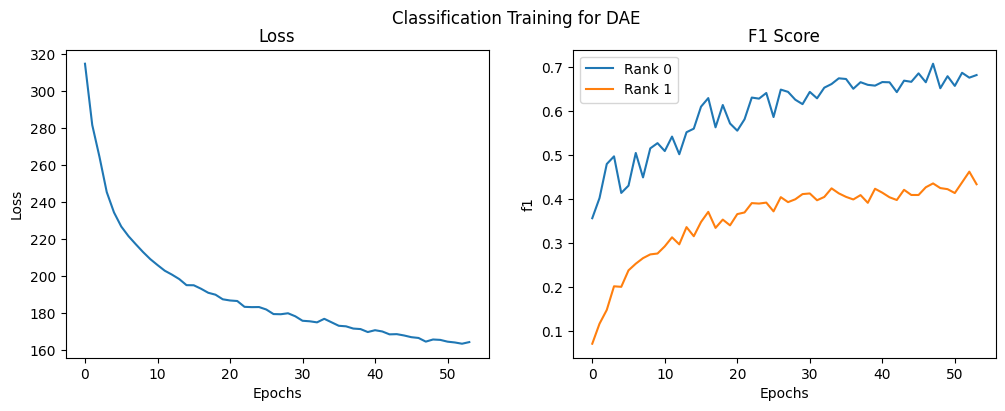

Test results: [0.70319, 0.45316]


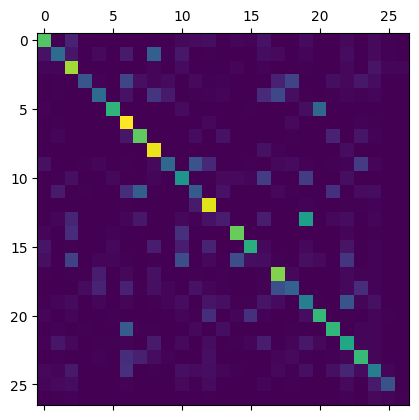

[[2642.    8.  365.    0.    0.    2.    3.    0.    1.    0.   77.   99.  140.    1.   58.   36.  174.    1.    0.  108.    1.    8.   81.    0.   93.   20.    0.]
 [ 176. 1267.  221.    0.   85.    7.  255.    1. 1080.   16.  233.    5.   27.   12.    0.    6.  113.   86.    5.   67.    3.    2.  119.    3.   98.   22.    0.]
 [  47.   58. 3108.    0.    5.    8.    1.    0.   57.    2.  112.    5.   12.    0.   59.    0.   36.    3.    0.   28.    5.    0.   73.    1.  189.   43.   57.]
 [   3.   21.    7.  965.   40.    0.  750.  144.   61.  103.    9.   85.   18.   40.    0.    1.    4.  338.  743.    7.    1.  128.   83.  234.  121.    3.    0.]
 [   1.   25.   10.   14. 1255.    0.  174.    1.  541.  261.    7.   20.   30.   67.    0.    3.  426.  767.  131.   18.    4.   26.   45.   29.   51.    3.    0.]
 [  30.    0.   13.    0.    0. 2353.    7.    0.   11.    0.  104.    4.    6.    0.    8.   24.    1.    0.    0.  129. 1206.    0.   11.    0.    2.    0.    0.]
 [   1.   

In [3]:
from torch import clamp, tensor
from torch.nn import (Module, Conv1d, ReLU, Sequential, Flatten, Linear,
                      CrossEntropyLoss, Dropout, MaxPool1d, LeakyReLU, ConvTranspose1d, Sigmoid)
from torch import stack, tensor, float32
from torch.func import vmap
import torch.nn.functional as F


class Unsqueeze(Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        return x.unsqueeze(self.dim)


class DAE_1(Module):
    """Denoising autoencoder 1."""
    def __init__(self, N, M):
        super(DAE_1, self).__init__()
        LATENT_SPACE_SIZE = 128
        self.encoder = Sequential(
            Conv1d(4, 32, kernel_size=5, padding=2),
            LeakyReLU(),
            MaxPool1d(kernel_size=2),
            Conv1d(32, 64, kernel_size=3, padding=1),
            LeakyReLU(),
            Flatten(),
            Linear(N * 64 // 2, N),
            LeakyReLU(),
            Linear(N, LATENT_SPACE_SIZE),
            LeakyReLU(),
        )
        self.decoder = Sequential(
            Linear(LATENT_SPACE_SIZE, N // 2),
            LeakyReLU(),
            Linear(N // 2, N),
            LeakyReLU(),
            Unsqueeze(1),
            ConvTranspose1d(1, 4, kernel_size=3, stride=1, padding=1),
            LeakyReLU(),
            Sigmoid(),
        )
        self.classifier = Linear(LATENT_SPACE_SIZE, M)

    def forward(self, x):
        if self.training:
            x_noisy = autoencoder.add_masking_noise(x, dropout_prob=0.2)
            x_noisy = clamp(x_noisy, 0.0, 1.0)
            latent = self.encoder(x_noisy)
        else:
            B, N = x.shape
            shifts = tensor([6, 4, 2, 0], device=x.device).view(1, 1, 4)
            x_expanded = x.unsqueeze(-1).to(int)
            tokens = (x_expanded >> shifts) & 0b11
            tokens = tokens.view(B, N * 4)
            one_hot = F.one_hot(tokens, num_classes=4).float()
            x = one_hot.permute(0, 2, 1)
            latent = self.encoder(x)
        classification = self.classifier(latent)
        reconstruction = self.decoder(latent)
        return classification, reconstruction


model = benchmark(
    autoencoder.Classifier(LENGTH, mapping, "cuda", DAE_1),
    "DAE",
    n_max_reads=8_000_000,
    patience=30,
)
matrix = confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=250)
print(matrix)

In [ ]:
from torch import arange
from torch.nn import (Module, Linear, Embedding, TransformerEncoderLayer,
                      TransformerEncoder)


class T_DAE_hybrid(Module):
    def __init__(self, N, M):
        super(T_DAE_hybrid, self).__init__()
        embed_dim = 128
        self.token_embedding = Embedding(256, embed_dim)
        self.position_embedding = Embedding(N, embed_dim)
        encoder_layer = TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=8,
            dim_feedforward=embed_dim * 4,
            dropout=0.1,
            activation='relu',
            batch_first=True  # makes input/output shape [B, L, D]
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=2)
        self.classifier = Linear(embed_dim, M)
        self.decoder = Sequential(
            Linear(embed_dim, N // 2),
            LeakyReLU(),
            Linear(N // 2, N),
            LeakyReLU(),
            Unsqueeze(1),
            ConvTranspose1d(1, 4, kernel_size=3, stride=1, padding=1),
            LeakyReLU(),
            Sigmoid(),
        )

    def forward(self, x):
        if self.training:
            x_noisy = autoencoder.add_masking_noise(x, dropout_prob=0.2)
            x_noisy = clamp(x_noisy, 0.0, 1.0)
            latent = self.encoder(x_noisy)
        else:
            B, N = x.shape
            shifts = tensor([6, 4, 2, 0], device=x.device).view(1, 1, 4)
            x_expanded = x.unsqueeze(-1).to(int)
            tokens = (x_expanded >> shifts) & 0b11
            tokens = tokens.view(B, N * 4)
            one_hot = F.one_hot(tokens, num_classes=4).float()
            x = one_hot.permute(0, 2, 1)
            latent = self.encoder(x)
        classification = self.classifier(latent)
        reconstruction = self.decoder(latent)
        return classification, reconstruction

    def forward(self, x):
        batch_size, seq_len = x.size()
        positions = arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        x = self.token_embedding(x) + self.position_embedding(positions)  # [B, L, D]
        x = self.transformer_encoder(x)  # [B, L, D]
        x = x.mean(dim=1)  # [B, D] - average pooling
        logits = self.classifier(x)  # [B, num_classes]
        return logits


model = benchmark(
    transformer.Classifier(LENGTH // 4, mapping, "cuda", T_2_tokens, use_tokens=True),
    "Transformer",
    n_max_reads=8_000_000,
    patience=20,
)
matrix = confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=250)
print(matrix)

### 3.5. Transformer / Denoising Autoencoder Hybrid Model

Number of parameters: 1_093_186


  1%|          | 392/68609 [01:12<66:39:26,  3.52s/it]

N Reads: 50_048 Loss: 285.22. F1: [0.50342, 0.16581]. Patience: 20


  1%|          | 783/68609 [02:37<107:12:48,  5.69s/it]

N Reads: 100_096 Loss: 229.19. F1: [0.59784, 0.2559]. Patience: 20


  2%|▏         | 1174/68609 [03:57<76:27:09,  4.08s/it] 

N Reads: 150_144 Loss: 212.24. F1: [0.59719, 0.31441]. Patience: 20


  2%|▏         | 1565/68609 [05:34<117:54:53,  6.33s/it]

N Reads: 200_192 Loss: 201.42. F1: [0.6278, 0.31778]. Patience: 20


  3%|▎         | 1956/68609 [06:55<78:18:50,  4.23s/it] 

N Reads: 250_240 Loss: 194.85. F1: [0.60863, 0.34316]. Patience: 20


  3%|▎         | 2347/68609 [08:18<75:54:00,  4.12s/it] 

N Reads: 300_288 Loss: 190.72. F1: [0.624, 0.35247]. Patience: 20


  4%|▍         | 2738/68609 [09:41<75:38:14,  4.13s/it] 

N Reads: 350_336 Loss: 185.02. F1: [0.63951, 0.37382]. Patience: 20


  5%|▍         | 3129/68609 [11:06<81:03:26,  4.46s/it] 

N Reads: 400_384 Loss: 180.94. F1: [0.6423, 0.39403]. Patience: 20


  5%|▌         | 3520/68609 [12:54<100:08:50,  5.54s/it]

N Reads: 450_432 Loss: 176.77. F1: [0.65745, 0.37212]. Patience: 19


  6%|▌         | 3911/68609 [14:15<71:41:54,  3.99s/it] 

N Reads: 500_480 Loss: 175.24. F1: [0.6556, 0.37887]. Patience: 18


  6%|▋         | 4302/68609 [15:38<70:36:00,  3.95s/it]

N Reads: 550_528 Loss: 171.68. F1: [0.62875, 0.38656]. Patience: 17


  7%|▋         | 4693/68609 [17:00<70:34:11,  3.97s/it]

N Reads: 600_576 Loss: 169.68. F1: [0.64211, 0.38912]. Patience: 16


  7%|▋         | 5084/68609 [18:23<71:01:53,  4.03s/it] 

N Reads: 650_624 Loss: 167.90. F1: [0.66782, 0.41045]. Patience: 16


  8%|▊         | 5475/68609 [19:47<70:42:09,  4.03s/it]

N Reads: 700_672 Loss: 165.17. F1: [0.66919, 0.42495]. Patience: 16


  9%|▊         | 5866/68609 [21:10<68:25:58,  3.93s/it]

N Reads: 750_720 Loss: 162.79. F1: [0.67043, 0.42022]. Patience: 15


  9%|▉         | 6257/68609 [22:34<69:51:10,  4.03s/it]

N Reads: 800_768 Loss: 161.53. F1: [0.66516, 0.42401]. Patience: 14


 10%|▉         | 6648/68609 [23:58<69:13:36,  4.02s/it]

N Reads: 850_816 Loss: 159.33. F1: [0.65154, 0.43035]. Patience: 14


 10%|█         | 7039/68609 [25:22<68:15:28,  3.99s/it]

N Reads: 900_864 Loss: 159.49. F1: [0.68825, 0.42198]. Patience: 13


 11%|█         | 7429/68609 [26:46<93:49:38,  5.52s/it]

N Reads: 950_912 Loss: 157.12. F1: [0.68372, 0.45514]. Patience: 13


 11%|█▏        | 7821/68609 [28:11<67:55:50,  4.02s/it]

N Reads: 1_000_960 Loss: 156.76. F1: [0.67046, 0.42768]. Patience: 12


 12%|█▏        | 8212/68609 [29:35<68:14:27,  4.07s/it]

N Reads: 1_051_008 Loss: 154.05. F1: [0.6753, 0.45687]. Patience: 12


 13%|█▎        | 8603/68609 [31:00<66:19:09,  3.98s/it]

N Reads: 1_101_056 Loss: 153.39. F1: [0.68622, 0.44383]. Patience: 11


 13%|█▎        | 8994/68609 [32:26<66:34:40,  4.02s/it]

N Reads: 1_151_104 Loss: 152.36. F1: [0.67018, 0.44785]. Patience: 10


 14%|█▎        | 9385/68609 [33:50<64:54:26,  3.95s/it]

N Reads: 1_201_152 Loss: 152.07. F1: [0.67752, 0.44116]. Patience: 9


 14%|█▍        | 9776/68609 [35:16<65:17:26,  4.00s/it]

N Reads: 1_251_200 Loss: 151.03. F1: [0.67741, 0.4512]. Patience: 8


 15%|█▍        | 10167/68609 [37:09<62:07:52,  3.83s/it] 

N Reads: 1_301_248 Loss: 149.12. F1: [0.68768, 0.47092]. Patience: 8


 15%|█▌        | 10558/68609 [38:46<60:40:31,  3.76s/it]

N Reads: 1_351_296 Loss: 148.49. F1: [0.6825, 0.46221]. Patience: 7


 16%|█▌        | 10949/68609 [40:12<61:08:53,  3.82s/it]

N Reads: 1_401_344 Loss: 148.12. F1: [0.69484, 0.44923]. Patience: 6


 17%|█▋        | 11340/68609 [41:36<60:42:05,  3.82s/it]

N Reads: 1_451_392 Loss: 147.70. F1: [0.69502, 0.482]. Patience: 6


 17%|█▋        | 11731/68609 [43:01<62:32:41,  3.96s/it]

N Reads: 1_501_440 Loss: 146.06. F1: [0.69955, 0.461]. Patience: 5


 18%|█▊        | 12122/68609 [44:27<61:54:31,  3.95s/it]

N Reads: 1_551_488 Loss: 147.12. F1: [0.69171, 0.46812]. Patience: 4


 18%|█▊        | 12513/68609 [45:52<61:45:01,  3.96s/it]

N Reads: 1_601_536 Loss: 145.78. F1: [0.69995, 0.45242]. Patience: 3


 19%|█▉        | 12904/68609 [47:18<61:59:23,  4.01s/it]

N Reads: 1_651_584 Loss: 145.00. F1: [0.68756, 0.45095]. Patience: 2


 19%|█▉        | 13295/68609 [48:45<61:02:11,  3.97s/it]

N Reads: 1_701_632 Loss: 143.78. F1: [0.7039, 0.47367]. Patience: 1


 20%|█▉        | 13686/68609 [50:11<58:48:22,  3.85s/it]

N Reads: 1_751_680 Loss: 143.61. F1: [0.7093, 0.48701]. Patience: 1


 21%|██        | 14075/68609 [51:37<3:19:59,  4.54it/s] 

N Reads: 1_801_728 Loss: 143.14. F1: [0.68198, 0.46522]. Patience: 0
The model is overfitting; stopping early.
Processed 1_801_728 reads.
Training took 3097.089 s.


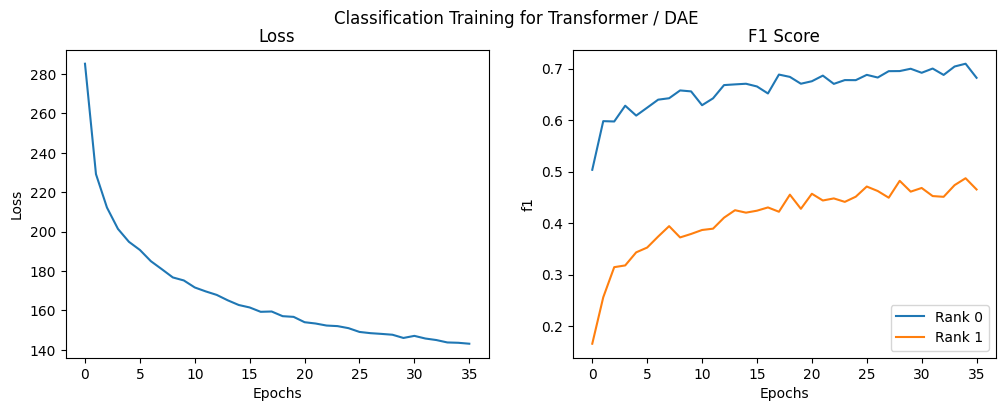

d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\metrics\_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(y_pred, input_name="y_pred")
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classe

Test results: [0.71448, 0.47493]


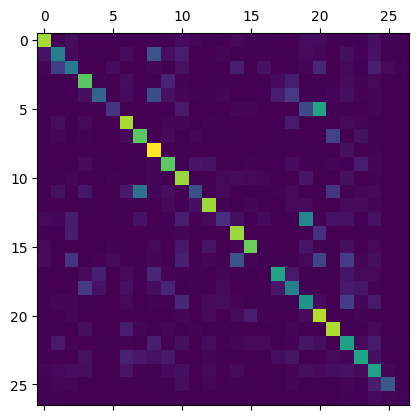

[[3072.    3.  118.    0.    1.    2.    3.    4.    0.   30.   98.   44.   24.    2.   72.   18.   15.    0.    0.  116.   98.   14.   14.   10.  145.   15.    0.]
 [ 176. 1536.   88.   10.   17.    9.   98.    9.  909.  147.  266.    4.   13.   53.   16.   16.   14.   12.   18.   94.   47.    7.  129.   28.  175.   17.    1.]
 [  52.  664. 1465.    0.    4.  101.    0.    0.   60.    2.  162.    2.   13.    2.  275.    1.  159.    2.    0.   45.  379.    0.   74.    7.  304.   95.   41.]
 [   8.   19.    0. 2641.   17.    0.  117.   27.   20.  341.   31.   11.    9.   25.    0.    1.    0.  111.  282.   18.    3.   25.  104.   28.   70.    1.    0.]
 [   2.   23.    2.  139. 1157.    1.  105.   20.  853.  164.   58.   33.   23.   57.    0.   13.   22.  282.  584.   36.   29.   67.  149.   29.   61.    0.    0.]
 [  35.    0.    4.    0.   14.  545.    2.    0.    2.    0.  247.    2.    4.    0.   60.   52.    0.    0.    0.  772. 2081.    0.   19.   10.   60.    0.    0.]
 [   0.  1

In [5]:
model = benchmark(
    hybrid.Classifier(LENGTH // 4, mapping, "cuda", hybrid.T_DAE_hybrid_1),
    "Transformer / DAE",
    n_max_reads=8_000_000,
    patience=20,
)
matrix = confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=250)
print(matrix)

In [4]:
from sklearn.metrics import precision_score


def rank_based_precision(
        mappings: dict, target: list[int], predictions: list[int]
        ) -> list[np.ndarray]:
    """Evaluate precision at multiple taxonomic ranks."""
    f = []
    for mapping in mappings:
        labels = list(set(mapping.values()))
        normalized_target = [mapping[int(v)] for v in list(target)]
        normalized_pred = [mapping[int(v)] for v in list(predictions)]
        f.append(
            precision_score(
                normalized_target,
                normalized_pred,
                average=None,
                labels=labels,
                zero_division=0.0
            )
        )
    return f


def evaluate(classifier, loader, device, mapping, permute=True):
    """Evaluate the F1 score at different taxonomic levels."""
    mappings = models.obtain_rank_based_mappings(mapping)
    ranks = []
    n_batches = 0
    with no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.type(float32).to(device)
            if permute:
                x_batch = x_batch.permute(0, 2, 1)  # Swap channels and sequence.
            y_batch = y_batch.to("cpu")
            predictions = classifier.predict(x_batch)
            ranks.append(rank_based_precision(mappings, y_batch, predictions))
            n_batches += 1
    collapsed_ranks = [np.zeros(len(r)) for r in ranks[0]]
    for rank in ranks:
        for i, result in enumerate(rank):
            collapsed_ranks[i] += result
    for i in range(len(collapsed_ranks)):
        collapsed_ranks[i] = np.mean(collapsed_ranks[i])
        collapsed_ranks[i] /= n_batches
    collapsed_ranks = [r for r in reversed(collapsed_ranks)]
    for i in range(len(collapsed_ranks) - 1):
        assert collapsed_ranks[i] > collapsed_ranks[i + 1]
    return collapsed_ranks

In [ ]:
result = evaluate(model, test_data, "cuda", mapping, permute=False)
rounded_result = [float(f"{r:.5}") for r in result]
print(rounded_result)

[0.7372, 0.50223]


Number of parameters: 2_408_386


  1%|          | 391/68609 [02:01<154:07:22,  8.13s/it]

N Reads: 50_048 Loss: 261.04. F1: [0.56094, 0.21786]. Patience: 20


  1%|          | 782/68609 [04:00<166:59:42,  8.86s/it]

N Reads: 100_096 Loss: 208.40. F1: [0.60297, 0.30613]. Patience: 20


  2%|▏         | 1173/68609 [06:20<230:18:12, 12.29s/it]

N Reads: 150_144 Loss: 196.55. F1: [0.63941, 0.36699]. Patience: 20


  2%|▏         | 1564/68609 [08:24<168:14:54,  9.03s/it]

N Reads: 200_192 Loss: 188.44. F1: [0.6394, 0.36304]. Patience: 19


  3%|▎         | 1955/68609 [10:57<265:25:19, 14.34s/it]

N Reads: 250_240 Loss: 181.56. F1: [0.6429, 0.39963]. Patience: 19


  3%|▎         | 2346/68609 [13:21<209:14:42, 11.37s/it]

N Reads: 300_288 Loss: 176.60. F1: [0.64669, 0.38472]. Patience: 18


  4%|▍         | 2737/68609 [15:29<169:51:12,  9.28s/it]

N Reads: 350_336 Loss: 171.15. F1: [0.65684, 0.42208]. Patience: 18


  5%|▍         | 3128/68609 [17:42<174:57:00,  9.62s/it]

N Reads: 400_384 Loss: 168.01. F1: [0.68155, 0.41586]. Patience: 17


  5%|▌         | 3519/68609 [19:47<160:11:59,  8.86s/it]

N Reads: 450_432 Loss: 166.17. F1: [0.66168, 0.41167]. Patience: 16


  6%|▌         | 3910/68609 [21:52<157:49:54,  8.78s/it]

N Reads: 500_480 Loss: 162.45. F1: [0.66656, 0.42255]. Patience: 16


  6%|▋         | 4301/68609 [23:56<155:29:11,  8.70s/it]

N Reads: 550_528 Loss: 160.58. F1: [0.66722, 0.39197]. Patience: 15


  7%|▋         | 4692/68609 [26:00<150:52:44,  8.50s/it]

N Reads: 600_576 Loss: 159.20. F1: [0.67683, 0.44219]. Patience: 15


  7%|▋         | 5083/68609 [28:04<151:54:00,  8.61s/it]

N Reads: 650_624 Loss: 157.06. F1: [0.68052, 0.46375]. Patience: 15


  8%|▊         | 5474/68609 [30:08<148:17:45,  8.46s/it]

N Reads: 700_672 Loss: 155.61. F1: [0.67579, 0.42537]. Patience: 14


  9%|▊         | 5865/68609 [32:11<146:33:13,  8.41s/it]

N Reads: 750_720 Loss: 153.95. F1: [0.6672, 0.43642]. Patience: 13


  9%|▉         | 6256/68609 [34:14<150:17:04,  8.68s/it]

N Reads: 800_768 Loss: 152.84. F1: [0.66687, 0.45396]. Patience: 12


 10%|▉         | 6647/68609 [36:18<144:40:24,  8.41s/it]

N Reads: 850_816 Loss: 151.14. F1: [0.68684, 0.44054]. Patience: 11


 10%|█         | 7038/68609 [38:21<144:03:14,  8.42s/it]

N Reads: 900_864 Loss: 150.34. F1: [0.67438, 0.46429]. Patience: 11


 11%|█         | 7429/68609 [40:25<142:32:06,  8.39s/it]

N Reads: 950_912 Loss: 149.83. F1: [0.67757, 0.45761]. Patience: 10


 11%|█▏        | 7820/68609 [42:28<143:58:38,  8.53s/it]

N Reads: 1_000_960 Loss: 148.46. F1: [0.67976, 0.472]. Patience: 10


 12%|█▏        | 8211/68609 [44:31<140:33:01,  8.38s/it]

N Reads: 1_051_008 Loss: 147.98. F1: [0.69206, 0.47139]. Patience: 9


 13%|█▎        | 8602/68609 [46:34<138:47:02,  8.33s/it]

N Reads: 1_101_056 Loss: 146.93. F1: [0.67068, 0.44611]. Patience: 8


 13%|█▎        | 8993/68609 [48:41<142:10:41,  8.59s/it]

N Reads: 1_151_104 Loss: 147.35. F1: [0.69233, 0.43901]. Patience: 7


 14%|█▎        | 9384/68609 [50:47<139:27:01,  8.48s/it]

N Reads: 1_201_152 Loss: 146.36. F1: [0.68808, 0.46554]. Patience: 6


 14%|█▍        | 9775/68609 [52:54<140:25:36,  8.59s/it]

N Reads: 1_251_200 Loss: 144.35. F1: [0.69436, 0.43562]. Patience: 5


 15%|█▍        | 10166/68609 [55:02<140:38:00,  8.66s/it]

N Reads: 1_301_248 Loss: 143.44. F1: [0.68751, 0.46024]. Patience: 4


 15%|█▌        | 10557/68609 [57:10<138:18:12,  8.58s/it]

N Reads: 1_351_296 Loss: 143.32. F1: [0.68408, 0.48089]. Patience: 4


 16%|█▌        | 10948/68609 [59:18<135:58:15,  8.49s/it]

N Reads: 1_401_344 Loss: 143.26. F1: [0.68914, 0.46639]. Patience: 3


 17%|█▋        | 11339/68609 [1:01:24<133:54:37,  8.42s/it]

N Reads: 1_451_392 Loss: 142.03. F1: [0.70211, 0.48009]. Patience: 2


 17%|█▋        | 11730/68609 [1:03:29<132:39:30,  8.40s/it]

N Reads: 1_501_440 Loss: 141.10. F1: [0.68501, 0.45572]. Patience: 1


 18%|█▊        | 12120/68609 [1:05:59<5:07:34,  3.06it/s]  

N Reads: 1_551_488 Loss: 141.11. F1: [0.69215, 0.4779]. Patience: 0
The model is overfitting; stopping early.
Processed 1_551_488 reads.
Training took 3959.616 s.


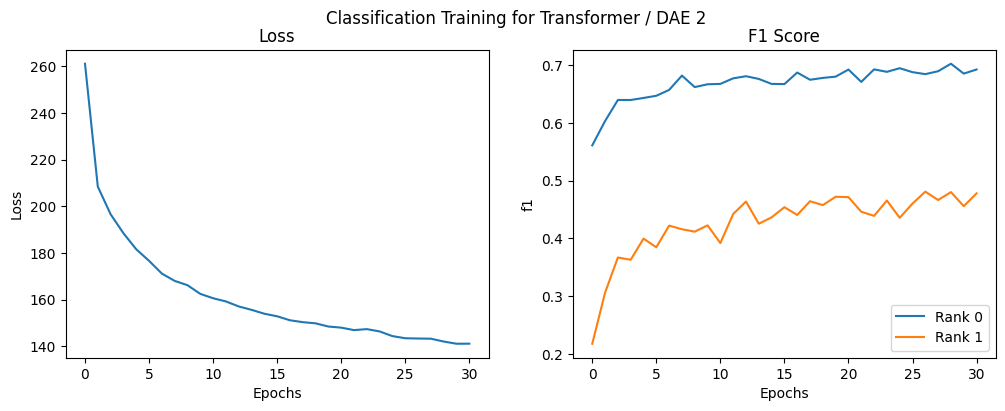

Test results: [0.70512, 0.47433]


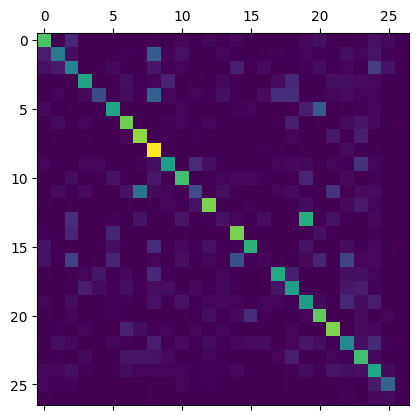

[[2620.   11.  413.    1.    0.    6.    4.    5.   20.    5.   76.   17.   84.    0.   77.   27.    4.    0.    0.   85.  163.   12.   11.   34.  162.   81.    0.]
 [ 289. 1481.  141.    6.    9.   27.   41.   24. 1026.   45.  169.    2.    5.   44.    9.   10.   28.   32.    5.   57.   42.   17.  130.   49.  188.   33.    0.]
 [ 159.  266. 1634.    0.    2.   80.    0.    0.  217.    3.   59.    4.    2.    0.  304.    2.  108.    7.    0.   40.  128.    0.   63.    2.  648.  180.    1.]
 [   4.   24.    1. 2151.   19.    0.  144.   27.   68.  347.    9.   24.    8.   72.    0.    0.    4.  110.  399.   17.    6.  128.  132.  102.  108.    5.    0.]
 [   6.   43.    1.   73.  809.    1.  125.   33. 1131.   65.   21.   49.   24.  144.    0.    8.  117.  458.  481.   27.   25.   56.  107.   53.   46.    6.    0.]
 [  80.    0.   17.    0.    8. 2123.    3.    0.    7.    0.   56.    0.    1.    0.   34.   66.   11.    0.    0.  310. 1061.    0.   27.   33.   72.    0.    0.]
 [   1.  1

NameError: name 'evaluate' is not defined

In [3]:
model = benchmark(
    hybrid.Classifier(LENGTH // 4, mapping, "cuda", hybrid.T_DAE_hybrid_2),
    "Transformer / DAE 2",
    n_max_reads=8_000_000,
    patience=20,
)
matrix = confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=250)
print(matrix)
result = evaluate(model, test_data, "cuda", mapping, permute=False)
rounded_result = [float(f"{r:.5}") for r in result]

In [5]:
result = evaluate(model, test_data, "cuda", mapping, permute=False)
rounded_result = [float(f"{r:.5}") for r in result]

In [6]:
print(rounded_result)

[0.70726, 0.50088]
